In [48]:
from __future__ import annotations

import re
import math
import json
import numpy as np
import pandas as pd
from pathlib import Path
from dataclasses import dataclass
from statistics import mean
from typing import Any, Dict, List, Sequence, Union, Tuple, Optional
from dotenv import load_dotenv, find_dotenv
import matplotlib.pyplot as plt

import Load_Data
import Data_Processing
import Chunking
import LLM_setting

In [49]:
# Read Data
file_path = Path("data/raw_filings/320193_000032019325000079_aapl-20250927.htm")
cfg = Load_Data.LoadData(file_path=file_path)
docs = Load_Data.load_data(cfg)

In [50]:
# Chunking
chunk_size= 2500
chunk_overlap = 250
data_processing=Chunking.DataProcessing(file_path,chunk_size,chunk_overlap)
doc_chunk =Chunking.chunks(data_processing)

In [4]:
result_path = Path("outputs/Apple_prompt_space_factorisation_10.json")
with result_path.open("r", encoding="utf-8") as f:
    result = json.load(f)
baseline_zero_shot = Path("outputs/baseline_zero_shot_FINAL_K_10.json")
baseline_minimal_template = Path("outputs/baseline_minimal_template_FINAL_K_10.json")
with baseline_zero_shot.open("r", encoding="utf-8") as z:
    baseline_zero_shot = json.load(z)
with baseline_minimal_template.open("r", encoding="utf-8") as m:
    baseline_minimal_template= json.load(m)

In [5]:
output_dir = Path("outputs/ablation_runs")

def is_run_file(p: Path) -> bool:
    if p.suffix.lower() != ".json":
        return False
    if p.name in {"done_variants.json", "manifest.json", "ablation_final_outputs.json"}:
        return False
    if p.name.endswith("_PARTIAL.json"):
        return False
    try:
        obj = json.loads(p.read_text(encoding="utf-8"))
    except Exception:
        return False
    return isinstance(obj, dict) and ("variant_id" in obj) and ("topics" in obj)

def safe_var_name(s: str) -> str:
    s = (s or "").lower()
    s = re.sub(r"[^a-z0-9_]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    if s and s[0].isdigit():
        s = "v_" + s
    return s

run_files = sorted([p for p in output_dir .iterdir() if is_run_file(p)], key=lambda p: p.name)
print("Run files found:", len(run_files))

runs_by_variant = {}
file_by_variant = {}

for p in run_files:
    run_obj = json.loads(p.read_text(encoding="utf-8"))
    vid = run_obj.get("variant_id") or p.stem
    runs_by_variant[vid] = run_obj
    file_by_variant[vid] = p.name

print("Loaded runs_by_variant:", len(runs_by_variant))
print("Example variant_ids:", list(runs_by_variant.keys())[:5])

latest_run_files = sorted(run_files, key=lambda p: p.stat().st_mtime, reverse=True)
if latest_run_files:
    p = latest_run_files[0]
    run = json.loads(p.read_text(encoding="utf-8"))
    print("\n--- Latest run ---")
    print("File:", p.name)
    print("Variant:", run.get("variant_id"))
    print("Parse failures:", run.get("parse_failures"))
    print("Final topics:", len(run.get("topics", [])))
    print("Example topic:", (run.get("topics") or [None])[0])
    print("Token usage:", run.get("token_usage"))


Run files found: 16
Loaded runs_by_variant: 15
Example variant_ids: ['abl_minus_exemplars_delimiter', 'abl_minus_role_rubric_exemplars_delimiter', 'abl_minus_rubric_exemplars_delimiter', 'abl_minus_role_exemplars_delimiter', 'abl_minus_role_rubric_delimiter']

--- Latest run ---
File: 20260110_123744_abl_minus_role.json
Variant: abl_minus_role
Parse failures: 0
Final topics: 10
Example topic: {'label': 'Competitive Landscape', 'keywords': ['market share', 'competition', 'market rivals', 'rival offerings', 'competitive dynamics', 'competitive intensity', 'competitors', 'integrated solutions'], 'support_chunks': 5}
Token usage: {'prompt_tokens': 85363, 'completion_tokens': 105715, 'total_tokens': 191078, 'tpm_last_60s_end': 14898, 'estimated_calls': 0}


In [6]:
def _as_text(x: Any) -> str:
    return getattr(x, "page_content", None) or str(x)

In [7]:
def _tokenize_for_coherence(text: str) -> List[str]:

    text = (text or "").lower()
    toks = re.findall(r"[a-z0-9]+(?:-[a-z0-9]+)*", text)

    try:
        import nltk
        from nltk.corpus import stopwords

        try:
            nltk.data.find("corpora/stopwords")
        except Exception:
            nltk.download("stopwords", quiet=True)

        sw = set(stopwords.words("english"))
        toks = [t for t in toks if t not in sw]
    except Exception:
        pass

    return [t for t in toks if len(t) >= 2]

In [8]:
def compute_npmi_cv(
    docs: Sequence[Union[str, Any]],
    topics: Sequence[Union[Dict[str, Any], Sequence[str]]],
    *,
    filter_no_below: int = 2,
    filter_no_above: float = 0.8,
    keep_n: int = 100_000,
    min_topic_tokens: int = 2,
) -> Dict[str, float]:

    from gensim.corpora.dictionary import Dictionary
    from gensim.models.coherencemodel import CoherenceModel

    texts_tok = [_tokenize_for_coherence(_as_text(d)) for d in docs if _as_text(d).strip()]
    texts_tok = [t for t in texts_tok if t]
    if not texts_tok:
        return {"npmi": float("nan"), "cv": float("nan")}

    dictionary = Dictionary(texts_tok)
    dictionary.filter_extremes(
        no_below=filter_no_below,
        no_above=filter_no_above,
        keep_n=keep_n,
    )
    vocab = dictionary.token2id

    topic_words: List[List[str]] = []

    for t in topics:
        if isinstance(t, dict):
            kws = t.get("keywords", [])
            if not isinstance(kws, list):
                continue
            raw_kw = [str(k).strip() for k in kws if str(k).strip()]
        else:
            raw_kw = [str(k).strip() for k in t if str(k).strip()]

        tokens: List[str] = []
        for kw in raw_kw:
            tokens.extend(_tokenize_for_coherence(kw))

        tokens_in_vocab = [tok for tok in tokens if tok in vocab]


        seen = set()
        uniq = []
        for tok in tokens_in_vocab:
            if tok not in seen:
                seen.add(tok)
                uniq.append(tok)

        if len(uniq) >= min_topic_tokens:
            topic_words.append(uniq)

    if not topic_words:
        return {"npmi": float("nan"), "cv": float("nan")}

    cm_npmi = CoherenceModel(
        topics=topic_words,
        texts=texts_tok,
        dictionary=dictionary,
        coherence="c_npmi",
    )
    cm_cv = CoherenceModel(
        topics=topic_words,
        texts=texts_tok,
        dictionary=dictionary,
        coherence="c_v",
    )

    return {"npmi": float(cm_npmi.get_coherence()), "cv": float(cm_cv.get_coherence())}


In [9]:
def chunk_to_text(chunk: Any) -> str:
    if isinstance(chunk, str):
        return chunk

    if hasattr(chunk, "page_content"):
        return chunk.page_content

    for attr in ("text", "content"):
        if hasattr(chunk, attr):
            return getattr(chunk, attr)

    if isinstance(chunk, dict):
        for key in ("page_content", "text", "content"):
            if key in chunk and isinstance(chunk[key], str):
                return chunk[key]

    return str(chunk)

In [10]:
coherence = compute_npmi_cv(docs=doc_chunk, topics=result["topics"])
print(coherence)

{'npmi': -0.16459744898641665, 'cv': 0.5367035314651601}


In [11]:
coherence_zeroshot = compute_npmi_cv(docs=doc_chunk, topics=baseline_zero_shot["topics"])
print(coherence_zeroshot )

{'npmi': -0.031323436183566054, 'cv': 0.5796453384348237}


In [12]:
coherence_minimal_template = compute_npmi_cv(docs=doc_chunk, topics=baseline_minimal_template["topics"])
print(coherence_minimal_template)

{'npmi': -0.015791173544375602, 'cv': 0.5745403033854108}


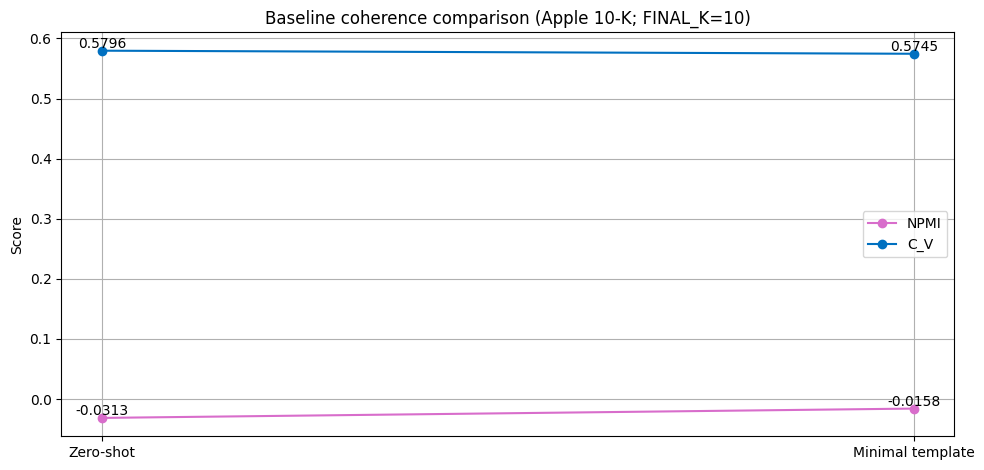

In [89]:
x_labels = ["Zero-shot", "Minimal template"]
x = list(range(len(x_labels)))

npmi = [coherence_zeroshot["npmi"],coherence_minimal_template["npmi"]]
cv   =[ coherence_zeroshot["cv"],coherence_minimal_template["cv"]]


plt.figure(figsize=(10, 4.8))

plt.plot(x, npmi, marker="o", label="NPMI",color ="#D86DCB")
plt.plot(x, cv, marker="o", label="C_V", color ="#0070C0")

plt.title("Baseline coherence comparison (Apple 10-K; FINAL_K=10)")
plt.ylabel("Score")
plt.xticks(x, x_labels)

for xi, yi in zip(x, npmi):
    plt.text(xi, yi, f"{yi:.4f}", ha="center", va="bottom")
for xi, yi in zip(x, cv):
    plt.text(xi, yi, f"{yi:.4f}", ha="center", va="bottom")

plt.legend()
plt.grid(True)
plt.tight_layout()
output_path= Path.cwd() / "Figures" / "Python-charts"
fig_name = 'baseline_coherence_professional.pdf'
plt.savefig(output_path/fig_name, dpi=300, bbox_inches="tight")
plt.show()


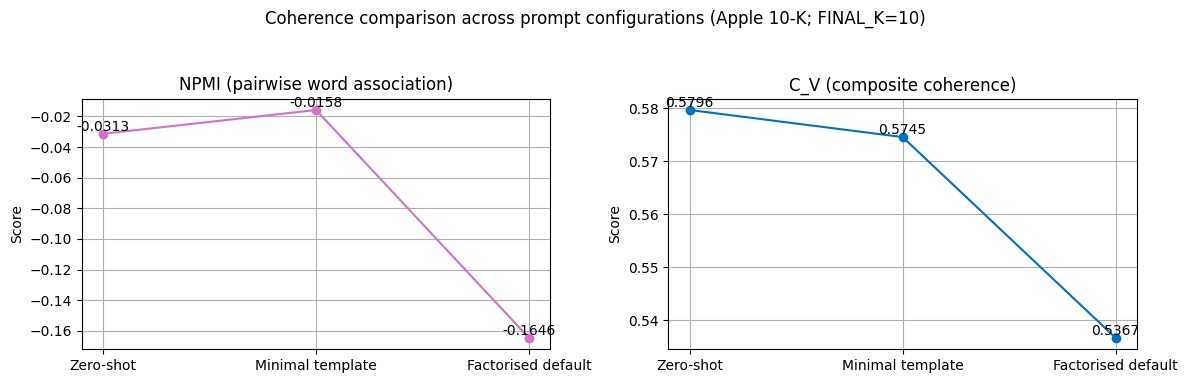

In [90]:
x_labels = ['Zero-shot', 'Minimal template', 'Factorised default']
x = list(range(len(x_labels)))

npmi = [coherence_zeroshot["npmi"], coherence_minimal_template["npmi"], coherence["npmi"]]
cv   = [coherence_zeroshot["cv"], coherence_minimal_template["cv"], coherence["cv"]]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3.6), sharex=True)

# Left: NPMI
ax = axes[0]
ax.plot(x, npmi, marker="o", color="#D86DCB")
ax.set_title("NPMI (pairwise word association)")
ax.set_ylabel("Score")
ax.set_xticks(x, x_labels)
ax.grid(True)

for xi, yi in zip(x, npmi):
    ax.text(xi, yi, f"{yi:.4f}", ha="center", va="bottom")

# Right: C_V
ax = axes[1]
ax.plot(x, cv, marker="o", color="#0070C0")
ax.set_title("C_V (composite coherence)")
ax.set_ylabel("Score")
ax.set_xticks(x, x_labels)
ax.grid(True)

for xi, yi in zip(x, cv):
    ax.text(xi, yi, f"{yi:.4f}", ha="center", va="bottom")

fig.suptitle("Coherence comparison across prompt configurations (Apple 10-K; FINAL_K=10)", y=1.05)

fig.tight_layout()

output_path = Path.cwd() / "Figures" / "Python-charts"
output_path.mkdir(parents=True, exist_ok=True)
fig_name = "coherence_three_configs_panels_v2.pdf"
fig.savefig(output_path / fig_name, dpi=300, bbox_inches="tight")

plt.show()

In [14]:
ablation_cv_npmi = {}

docs = [chunk_to_text(c) for c in doc_chunk]

for vid, run_obj in runs_by_variant.items():
    topic_keywords = [t.get("keywords", []) for t in run_obj.get("topics", []) if t.get("keywords")]

    if not topic_keywords:
        ablation_cv_npmi[vid] = {"npmi": math.nan, "cv": math.nan}
        continue

    res = compute_npmi_cv(docs=docs, topics=topic_keywords)

    ablation_cv_npmi[vid] = {
        "npmi": float(res["npmi"]),
        "cv": float(res["cv"]),
    }

ablation_cv_npmi

{'abl_minus_exemplars_delimiter': {'npmi': -0.12140494623439568,
  'cv': 0.5652698816267554},
 'abl_minus_role_rubric_exemplars_delimiter': {'npmi': nan, 'cv': nan},
 'abl_minus_rubric_exemplars_delimiter': {'npmi': nan, 'cv': nan},
 'abl_minus_role_exemplars_delimiter': {'npmi': -0.1794953919292881,
  'cv': 0.5482859356552947},
 'abl_minus_role_rubric_delimiter': {'npmi': nan, 'cv': nan},
 'abl_minus_rubric_delimiter': {'npmi': nan, 'cv': nan},
 'abl_minus_role_delimiter': {'npmi': -0.17516635008800857,
  'cv': 0.5515417192736287},
 'abl_minus_delimiter': {'npmi': -0.1849808349394248, 'cv': 0.533205790332964},
 'abl_minus_role_rubric_exemplars': {'npmi': nan, 'cv': nan},
 'abl_minus_rubric_exemplars': {'npmi': nan, 'cv': nan},
 'abl_minus_role_exemplars': {'npmi': -0.14235988744027953,
  'cv': 0.5346158169856114},
 'abl_minus_exemplars': {'npmi': -0.09001412436010711,
  'cv': 0.5645348898640852},
 'abl_minus_role_rubric': {'npmi': nan, 'cv': nan},
 'abl_minus_rubric': {'npmi': nan, 'c

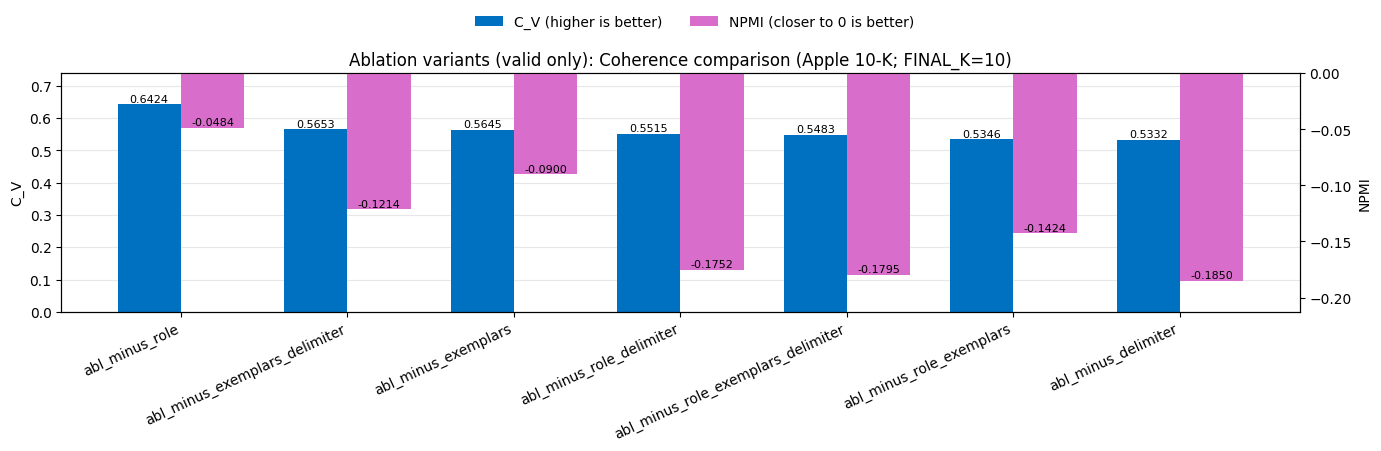

In [91]:
valid_items = [
    (vid, d) for vid, d in ablation_cv_npmi.items()
    if d is not None
    and np.isfinite(d.get("cv", np.nan))
    and np.isfinite(d.get("npmi", np.nan))
]

if not valid_items:
    raise ValueError("No valid variants found (all cv/npmi are NaN). Check your topic extraction outputs.")

valid_items.sort(key=lambda x: x[1]["cv"], reverse=True)

variants = [vid for vid, _ in valid_items]
cv_vals  = [d["cv"] for _, d in valid_items]
npmi_vals = [d["npmi"] for _, d in valid_items]


x = np.arange(len(variants))
w = 0.38

fig, ax_cv = plt.subplots(figsize=(14, 4.2))


bars_cv = ax_cv.bar(x - w/2, cv_vals, width=w, label="C_V (higher is better)",color="#0070C0")
ax_cv.set_ylabel("C_V")
ax_cv.set_ylim(0, max(cv_vals) * 1.15)
ax_cv.grid(True, axis="y", alpha=0.3)
ax_cv.set_axisbelow(True)

ax_npmi = ax_cv.twinx()
bars_npmi = ax_npmi.bar(x + w/2, npmi_vals, width=w, label="NPMI (closer to 0 is better)",color="#D86DCB")
ax_npmi.set_ylabel("NPMI")

min_npmi = min(npmi_vals)
ax_npmi.set_ylim(min_npmi * 1.15, 0)

# X labels
ax_cv.set_xticks(x)
ax_cv.set_xticklabels(variants, rotation=25, ha="right")

# Title
ax_cv.set_title("Ablation variants (valid only): Coherence comparison (Apple 10-K; FINAL_K=10)")

for rect, v in zip(bars_cv, cv_vals):
    ax_cv.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
               f"{v:.4f}", ha="center", va="bottom", fontsize=8)

for rect, v in zip(bars_npmi, npmi_vals):
    ax_npmi.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
                 f"{v:.4f}", ha="center", va="bottom", fontsize=8)

handles1, labels1 = ax_cv.get_legend_handles_labels()
handles2, labels2 = ax_npmi.get_legend_handles_labels()

fig.legend(
    handles1 + handles2,
    labels1 + labels2,
    loc="upper center",
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, 1.08)
)

plt.tight_layout()
output_path.mkdir(parents=True, exist_ok=True)
fig_name = "ablation_cv_npmi_merged_v2.pdf"
fig.savefig(output_path / fig_name, dpi=300, bbox_inches="tight")
plt.show()

#### Distinctness Ratio

In [15]:
def distinctness_ratio(
    topics: Sequence[Union[Dict[str, Any], Sequence[str]]],
    *,
    use_lowercase: bool = True,
) -> float:

    keyword_sets: List[set] = []

    for t in topics:
        if isinstance(t, dict):
            kws = t.get("keywords", [])
            if not isinstance(kws, list):
                continue
            words = [str(k).strip() for k in kws if str(k).strip()]
        else:
            words = [str(k).strip() for k in t if str(k).strip()]

        if use_lowercase:
            words = [w.lower() for w in words]

        s = set(words)
        if s:
            keyword_sets.append(s)

    n = len(keyword_sets)
    if n <= 1:
        return 1.0

    overlaps: List[float] = []
    for i in range(n):
        for j in range(i + 1, n):
            a, b = keyword_sets[i], keyword_sets[j]
            union = len(a | b)
            if union == 0:
                overlaps.append(0.0)
            else:
                overlaps.append(len(a & b) / union)

    avg_overlap = sum(overlaps) / len(overlaps) if overlaps else 0.0
    return max(0.0, min(1.0, 1.0 - avg_overlap))


In [16]:
def _normalize_keyword(k: str) -> str:
    k = (k or "").strip().lower()
    k = re.sub(r"[^\w\s\-]", "", k)
    k = re.sub(r"\s+", " ", k).strip()

    if len(k) > 4:
        if k.endswith("ies"):
            k = k[:-3] + "y"
        elif k.endswith("sses"):
            pass
        elif k.endswith("ses"):
            k = k[:-1]
        elif k.endswith("s") and not k.endswith(("ss", "us")):
            k = k[:-1]

    return k


In [17]:
def distinctness_ratio_normalized(
    topics: Sequence[Union[Dict[str, Any], Sequence[str]]],
) -> float:
    keyword_sets: List[set] = []

    for t in topics:
        if isinstance(t, dict):
            kws = t.get("keywords", [])
            if not isinstance(kws, list):
                continue
            words = [str(k) for k in kws]
        else:
            words = [str(k) for k in t]

        normed = [_normalize_keyword(w) for w in words]
        normed = [w for w in normed if w]
        s = set(normed)
        if s:
            keyword_sets.append(s)

    n = len(keyword_sets)
    if n <= 1:
        return 1.0

    overlaps: List[float] = []
    for i in range(n):
        for j in range(i + 1, n):
            a, b = keyword_sets[i], keyword_sets[j]
            union = len(a | b)
            overlaps.append((len(a & b) / union) if union else 0.0)

    avg_overlap = sum(overlaps) / len(overlaps) if overlaps else 0.0
    return max(0.0, min(1.0, 1.0 - avg_overlap))



In [18]:
dr = distinctness_ratio_normalized(result["topics"])
print("Distinctness ratio:", dr)

Distinctness ratio: 0.991908831908832


In [19]:
dr_zeroshot = distinctness_ratio_normalized(baseline_zero_shot["topics"])
print("Distinctness ratio:", dr_zeroshot)

Distinctness ratio: 0.9811111111111112


In [20]:
dr_minimal_template = distinctness_ratio_normalized(baseline_minimal_template["topics"])
print("Distinctness ratio:", dr_minimal_template)

Distinctness ratio: 0.9985185185185185


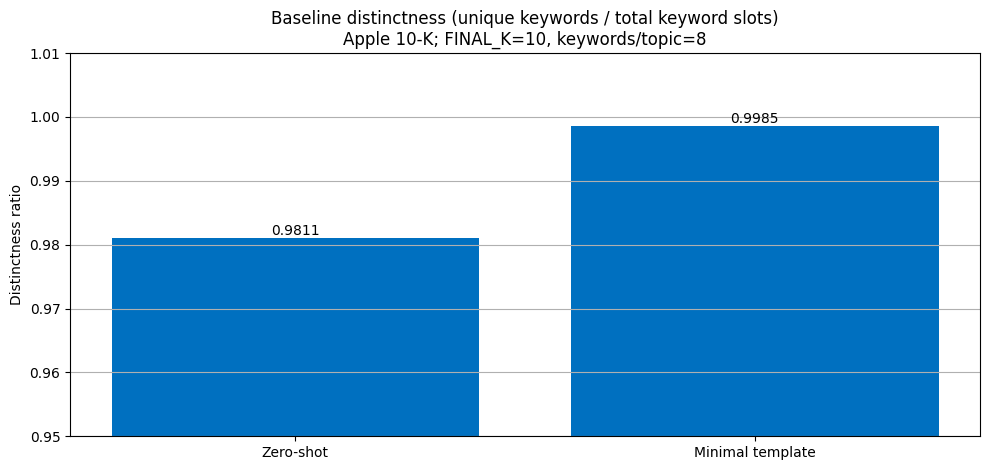

In [92]:
x_labels = ["Zero-shot", "Minimal template"]

distinctness  =[dr_zeroshot,dr_minimal_template]

plt.figure(figsize=(10, 4.8))

bars = plt.bar(x_labels, distinctness,color="#0070C0")

plt.title(
    "Baseline distinctness (unique keywords / total keyword slots)\n"
    "Apple 10-K; FINAL_K=10, keywords/topic=8"
)
plt.ylabel("Distinctness ratio")
plt.ylim(0.95, 1.01)
plt.grid(True, axis="y")

for bar, val in zip(bars, distinctness):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{val:.4f}",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
output_path= Path.cwd() / "Figures" / "Python-charts"
fig_name = 'baseline_distinctness_professional.pdf'
plt.savefig(output_path/fig_name, dpi=300, bbox_inches="tight")
plt.show()

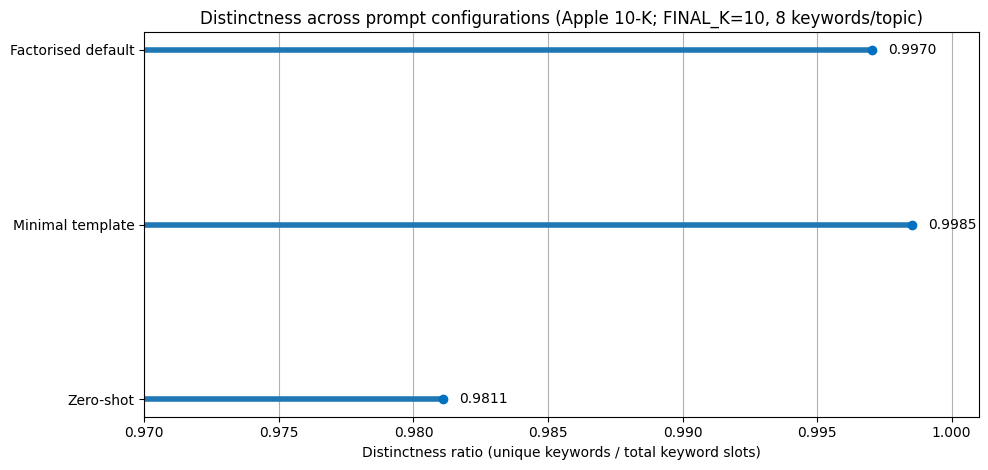

In [93]:
labels = ["Zero-shot", "Minimal template", "Factorised default"]
vals   = [dr_zeroshot,dr_minimal_template,dr ]

fig, ax = plt.subplots(figsize=(10, 4.8))

y = range(len(labels))
ax.hlines(y=y, xmin=min(vals) - 0.02, xmax=vals, linewidth=4)
ax.plot(vals, y, marker="o", linestyle="None",color="#0070C0")

# Axes/labels
ax.set_yticks(list(y))
ax.set_yticklabels(labels)
ax.set_xlim(0.97, 1.001)
ax.set_xlabel("Distinctness ratio (unique keywords / total keyword slots)")
ax.set_title("Distinctness across prompt configurations (Apple 10-K; FINAL_K=10, 8 keywords/topic)")
ax.grid(True, axis="x")

# Value labels
for yi, v in zip(y, vals):
    ax.text(v + 0.0006, yi, f"{v:.4f}", va="center")

plt.tight_layout()
output_path= Path.cwd() / "Figures" / "Python-charts"
fig_name = 'distinctness_three_configs_lollipop.pdf'
plt.savefig(output_path/fig_name, dpi=300, bbox_inches="tight")
plt.show()

In [22]:
ablation_distinctness_ratio = {}

docs = [chunk_to_text(c) for c in doc_chunk]

for vid, run_obj in runs_by_variant.items():
    topics = run_obj.get("topics", [])

    if not topics:
        ablation_distinctness_ratio[vid] = {"distinctness_ratio": math.nan}
        continue

    dr = distinctness_ratio_normalized(topics)
    ablation_distinctness_ratio[vid] = {"distinctness_ratio": float(dr)}

ablation_distinctness_ratio

{'abl_minus_exemplars_delimiter': {'distinctness_ratio': 0.9985185185185185},
 'abl_minus_role_rubric_exemplars_delimiter': {'distinctness_ratio': nan},
 'abl_minus_rubric_exemplars_delimiter': {'distinctness_ratio': nan},
 'abl_minus_role_exemplars_delimiter': {'distinctness_ratio': 0.9938624338624339},
 'abl_minus_role_rubric_delimiter': {'distinctness_ratio': nan},
 'abl_minus_rubric_delimiter': {'distinctness_ratio': nan},
 'abl_minus_role_delimiter': {'distinctness_ratio': 0.9938624338624339},
 'abl_minus_delimiter': {'distinctness_ratio': 0.9953439153439153},
 'abl_minus_role_rubric_exemplars': {'distinctness_ratio': nan},
 'abl_minus_rubric_exemplars': {'distinctness_ratio': nan},
 'abl_minus_role_exemplars': {'distinctness_ratio': 1.0},
 'abl_minus_exemplars': {'distinctness_ratio': 1.0},
 'abl_minus_role_rubric': {'distinctness_ratio': nan},
 'abl_minus_rubric': {'distinctness_ratio': nan},
 'abl_minus_role': {'distinctness_ratio': 0.997037037037037}}

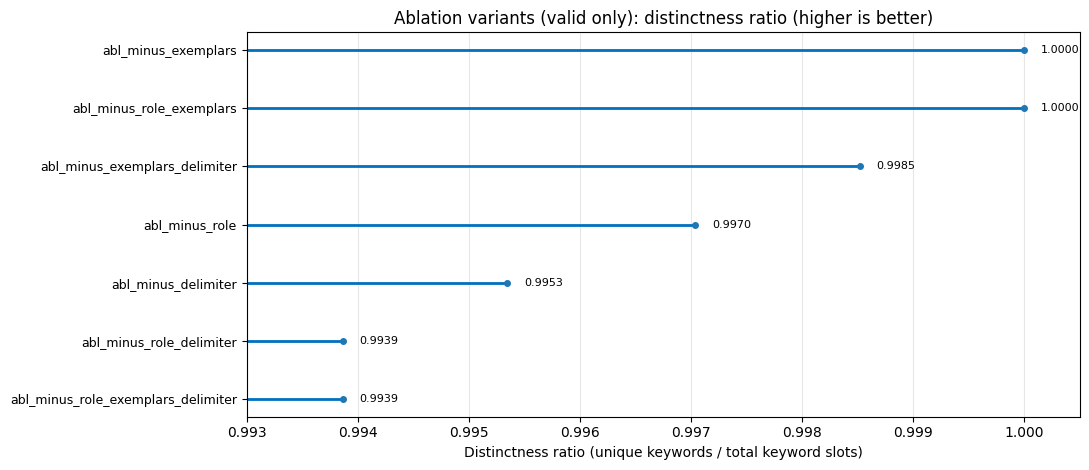

In [94]:
valid_items = [
    (vid, d["distinctness_ratio"])
    for vid, d in ablation_distinctness_ratio.items()
    if d is not None and np.isfinite(d.get("distinctness_ratio", np.nan))
]

if not valid_items:
    raise ValueError("No valid distinctness_ratio values found (all are NaN).")

valid_items.sort(key=lambda t: t[1])

variants = [v for v, _ in valid_items]
vals = np.array([dr for _, dr in valid_items], dtype=float)

fig, ax = plt.subplots(figsize=(11, 4.8))

y = np.arange(len(variants))

xmin = float(np.floor((vals.min() - 0.0005) * 1000) / 1000)
ax.hlines(y=y, xmin=xmin, xmax=vals, linewidth=2,color="#0070C0")
ax.plot(vals, y, "o", markersize=4)

ax.set_yticks(y)
ax.set_yticklabels(variants, fontsize=9)

ax.set_xlabel("Distinctness ratio (unique keywords / total keyword slots)")
ax.set_title("Ablation variants (valid only): distinctness ratio (higher is better)")

ax.grid(True, axis="x", alpha=0.3)
ax.set_axisbelow(True)

ax.set_xlim(xmin, min(1.0005, vals.max() + 0.0005))

for yi, v in zip(y, vals):
    ax.text(v + 0.00015, yi, f"{v:.4f}", va="center", fontsize=8)

plt.tight_layout()
output_path= Path.cwd() / "Figures" / "Python-charts"
fig_name = 'ablation_distinctness_lollipop.pdf'
plt.savefig(output_path/fig_name, dpi=300, bbox_inches="tight")
plt.show()

#### LLM as judge

In [52]:
_JSON_OBJ_RE = re.compile(r"\{.*\}", flags=re.DOTALL)

In [53]:
def _parse_json_loose_str(s: str) -> Dict[str, Any]:
    s = (s or "").strip()
    if not s:
        return {}
    try:
        return json.loads(s)
    except Exception:
        pass
    m = _JSON_OBJ_RE.search(s)
    if m:
        try:
            return json.loads(m.group(0))
        except Exception:
            return {}
    return {}

In [54]:
def _as_topic_list(topics: Sequence[Dict[str, Any]]) -> List[Dict[str, Any]]:
    out: List[Dict[str, Any]] = []
    for t in topics:
        if not isinstance(t, dict):
            continue
        label = str(t.get("label", "")).strip()
        kws = t.get("keywords", [])
        if not label or not isinstance(kws, list):
            continue
        keywords = [str(k).strip() for k in kws if str(k).strip()]
        out.append({"label": label, "keywords": keywords})
    return out


In [55]:
def _build_clarity_judge_prompt(topic_batch: List[Dict[str, Any]]) -> str:
    topics_json = json.dumps(topic_batch, ensure_ascii=False)

    return (
        "You are an expert evaluator for topic modeling outputs.\n"
        "Task: Rate CLARITY (interpretability) for each topic based ONLY on its label and keywords.\n\n"
        "Clarity scale (integer 1–5):\n"
        "1 = Unclear/meaningless: label is vague or keywords look random/artifact-like.\n"
        "2 = Mostly unclear: weak theme, many irrelevant/artifact tokens.\n"
        "3 = Somewhat clear: theme is visible but still generic or mixed.\n"
        "4 = Clear: label fits, keywords are mostly consistent and informative.\n"
        "5 = Very clear: concise label + highly consistent, domain-meaningful keywords.\n\n"
        "Notes:\n"
        "- Do NOT evaluate coherence statistically; only interpretability/clarity.\n"
        "- Penalize boilerplate artifacts (dates, IDs, XBRL tags like 'us-gaap', ticker-like codes).\n\n"
        "Return valid JSON only (no Markdown, no extra text).\n"
        "Schema:\n"
        "{"
        "\"ratings\":[{\"label\":str,\"score\":int,\"rationale\":str}]"
        "}\n\n"
        "TOPICS:\n"
        f"{topics_json}"
    )

In [56]:
@dataclass(frozen=True)
class ClarityResult:
    mean_score: float
    scores: List[Optional[int]]
    ratings: List[Dict[str, Any]]
    raw_responses: List[str]


def llm_as_judge_clarity_score(
    *,
    judge_llm,
    topics: Sequence[Dict[str, Any]],
    batch_size: int = 10,
) -> ClarityResult:

    topics_clean = _as_topic_list(topics)
    if not topics_clean:
        return ClarityResult(mean_score=float("nan"), scores=[], ratings=[], raw_responses=[])

    all_ratings: List[Dict[str, Any]] = []
    raw_responses: List[str] = []

    idx_by_label: Dict[str, List[int]] = {}
    for i, t in enumerate(topics_clean):
        idx_by_label.setdefault(t["label"], []).append(i)

    scores: List[Optional[int]] = [None] * len(topics_clean)

    for start in range(0, len(topics_clean), batch_size):
        batch = topics_clean[start : start + batch_size]
        prompt = _build_clarity_judge_prompt(batch)

        resp = judge_llm.invoke(prompt)
        content = getattr(resp, "content", str(resp))
        raw_responses.append(content)

        data = _parse_json_loose_str(content)
        ratings = data.get("ratings", [])
        if not isinstance(ratings, list):
            continue

        for r in ratings:
            if not isinstance(r, dict):
                continue
            label = str(r.get("label", "")).strip()
            score = r.get("score", None)

            try:
                score_int = int(score)
            except Exception:
                continue

            if score_int < 1 or score_int > 5 or not label:
                continue

            all_ratings.append(
                {"label": label, "score": score_int, "rationale": str(r.get("rationale", "")).strip()}
            )

            if label in idx_by_label:
                for idx in idx_by_label[label]:
                    if scores[idx] is None:
                        scores[idx] = score_int
                        break

    valid = [s for s in scores if isinstance(s, int)]
    mean_score = float(mean(valid)) if valid else float("nan")

    return ClarityResult(
        mean_score=mean_score,
        scores=scores,
        ratings=all_ratings,
        raw_responses=raw_responses,
    )


In [57]:
_ = load_dotenv(find_dotenv())

In [21]:
model ="llama-3.1-8b-instant"
temperature = 0
llm_setting= LLM_setting.LLMSetting(MODEL=model, TEMPERATURE=temperature)
judge_llm = LLM_setting.setting(llm_setting)
clarity = llm_as_judge_clarity_score(judge_llm=judge_llm, topics=result["topics"], batch_size=10)
print("Mean clarity:", clarity.mean_score)
print(clarity.ratings[:])

Mean clarity: 4.6
[{'label': 'Competitive Landscape', 'score': 5, 'rationale': "Concise label + highly consistent, domain-meaningful keywords such as 'competition', 'market share', and 'industry rivals'."}, {'label': 'Internal Control over Financial Reporting', 'score': 5, 'rationale': "Concise label + highly consistent, domain-meaningful keywords such as 'internal control', 'financial reporting', and 'COSO'."}, {'label': 'Financial Condition Impact', 'score': 5, 'rationale': "Concise label + highly consistent, domain-meaningful keywords such as 'financial condition', 'earnings impact', and 'risk assessment'."}, {'label': 'Income Tax Provision', 'score': 2, 'rationale': "Weak theme, many irrelevant/artifact tokens such as '2025 provision', '2024 provision', and '2023 provision'."}, {'label': 'Legal Proceedings', 'score': 5, 'rationale': "Concise label + highly consistent, domain-meaningful keywords such as 'legal proceedings', 'litigation', and 'lawsuits'."}, {'label': 'Pricing Pressur

In [30]:
out_path = Path("outputs") / f"prompt_space_factorisation_LLM_judge.json"
out_path.parent.mkdir(parents=True, exist_ok=True)
out_path.write_text(json.dumps(clarity.ratings[:] , indent=2, ensure_ascii=False), encoding="utf-8")
print(f"Saved: {out_path}")

Saved: outputs/prompt_space_factorisation_LLM_judge.json


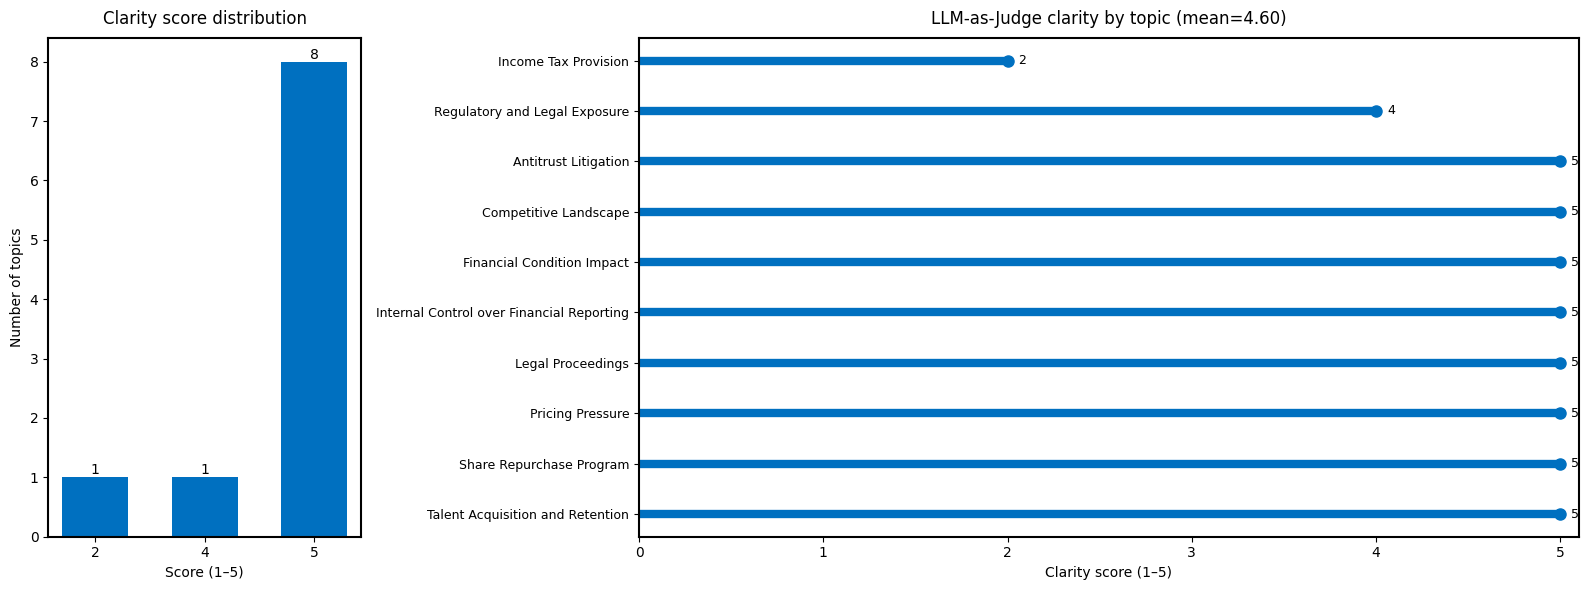

In [95]:
JSON_PATH = Path("outputs") / f"prompt_space_factorisation_LLM_judge.json"

# Load
with JSON_PATH.open("r", encoding="utf-8") as f:
    data = json.load(f)

topics = [d["label"] for d in data]
scores = np.array([d["score"] for d in data], dtype=float)

uniq_scores, counts = np.unique(scores.astype(int), return_counts=True)

fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 3])

ax_left = fig.add_subplot(gs[0, 0])
ax_right = fig.add_subplot(gs[0, 1])

for ax in (ax_left, ax_right):
    ax.tick_params(colors="black")
    for spine in ax.spines.values():
        spine.set_visible(False)

BLUE = "#0070C0"
GRID = (1, 1, 1, 0.7)

x_labels = [str(s) for s in uniq_scores]
ax_left.bar(x_labels, counts, color=BLUE, width=0.6)


ax_left.set_title("Clarity score distribution", color="black", pad=10)
ax_left.set_xlabel("Score (1–5)", color="black")
ax_left.set_ylabel("Number of topics", color="black")
ax_left.yaxis.grid(True, color=GRID, linewidth=1)
ax_left.set_axisbelow(True)

for xi, c in zip(range(len(counts)), counts):
    ax_left.text(xi, c, f"{int(c)}", ha="center", va="bottom", color="black", fontsize=10)

order = np.lexsort((np.array(topics), scores))
topics_sorted = [topics[i] for i in order]
scores_sorted = scores[order]

y = np.arange(len(topics_sorted))

ax_right.hlines(y=y, xmin=0, xmax=scores_sorted, color=BLUE, linewidth=6)
ax_right.plot(scores_sorted, y, "o", color=BLUE, markersize=8)

ax_right.set_yticks(y)
ax_right.set_yticklabels(topics_sorted, color="black", fontsize=9)
ax_right.invert_yaxis()

ax_right.set_xlim(0, 5.1)
ax_right.set_xlabel("Clarity score (1–5)", color="black")
ax_right.set_title(
    f"LLM-as-Judge clarity by topic (mean={np.mean(scores):.2f})",
    color="black",
    pad=10,
)

ax_right.xaxis.grid(True, color=GRID, linewidth=1)
ax_right.set_axisbelow(True)

for yi, v in zip(y, scores_sorted):
    ax_right.text(v + 0.06, yi, f"{int(v)}", va="center", color="black", fontsize=9)

def add_border(ax, color="black", lw=1.5):
    for side in ["left", "right", "top", "bottom"]:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_color(color)
        ax.spines[side].set_linewidth(lw)

add_border(ax_left)
add_border(ax_right)

plt.tight_layout()
output_path= Path.cwd() / "Figures" / "Python-charts"
fig_name = 'factorised_clarity_dashboard_v4.pdf'
plt.savefig(output_path/fig_name, dpi=300, bbox_inches="tight")
plt.show()

In [22]:
clarity_zeroshot = llm_as_judge_clarity_score(judge_llm=judge_llm, topics=baseline_zero_shot["topics"], batch_size=10)
print("Mean clarity:", clarity_zeroshot.mean_score)
print(clarity_zeroshot.ratings[:])

Mean clarity: 3.3
[{'label': 'Financial Impact', 'score': 4, 'rationale': 'The label fits the keywords, which are mostly consistent and informative about financial aspects.'}, {'label': 'Regulatory Compliance', 'score': 4, 'rationale': 'The label fits the keywords, which are mostly consistent and informative about regulatory aspects.'}, {'label': 'Corporate Governance', 'score': 4, 'rationale': 'The label fits the keywords, which are mostly consistent and informative about governance aspects.'}, {'label': 'Business Impact', 'score': 3, 'rationale': 'The label is somewhat clear, but the keywords are generic and mixed, including both financial and operational aspects.'}, {'label': 'Risk Factors', 'score': 4, 'rationale': 'The label fits the keywords, which are mostly consistent and informative about risk aspects.'}, {'label': 'Antitrust Litigation', 'score': 4, 'rationale': 'The label fits the keywords, which are mostly consistent and informative about antitrust aspects.'}, {'label': 'Le

In [23]:
out_path = Path("outputs") / f"zeroshot_LLM_judge.json"
out_path.parent.mkdir(parents=True, exist_ok=True)
out_path.write_text(json.dumps(clarity_zeroshot.ratings[:] , indent=2, ensure_ascii=False), encoding="utf-8")
print(f"Saved: {out_path}")

Saved: outputs/zeroshot_LLM_judge.json


In [25]:
clarity_minimal_template = llm_as_judge_clarity_score(judge_llm=judge_llm, topics=baseline_minimal_template["topics"], batch_size=10)
print("Mean clarity:",clarity_minimal_template.mean_score)
print(clarity_minimal_template.ratings[:])

Mean clarity: 3.3
[{'label': 'Legal Proceedings', 'score': 4, 'rationale': 'The label is clear and the keywords are mostly consistent and informative, indicating a strong theme of legal proceedings.'}, {'label': 'Financial Impact', 'score': 4, 'rationale': 'The label is clear and the keywords are mostly consistent and informative, indicating a strong theme of financial impact.'}, {'label': 'Company Identification', 'score': 2, 'rationale': "The label is somewhat clear, but the keywords include boilerplate artifacts like 'Apple Inc.' and 'used', which detract from the clarity of the topic."}, {'label': 'Competitive Landscape', 'score': 4, 'rationale': 'The label is clear and the keywords are mostly consistent and informative, indicating a strong theme of competitive landscape.'}, {'label': 'Debt Instruments', 'score': 4, 'rationale': 'The label is clear and the keywords are mostly consistent and informative, indicating a strong theme of debt instruments.'}, {'label': 'Product Portfolio'

In [26]:
out_path = Path("outputs") / f"minimal_template_judge.json"
out_path.parent.mkdir(parents=True, exist_ok=True)
out_path.write_text(json.dumps(clarity_minimal_template.ratings[:] , indent=2, ensure_ascii=False), encoding="utf-8")
print(f"Saved: {out_path}")

Saved: outputs/minimal_template_judge.json


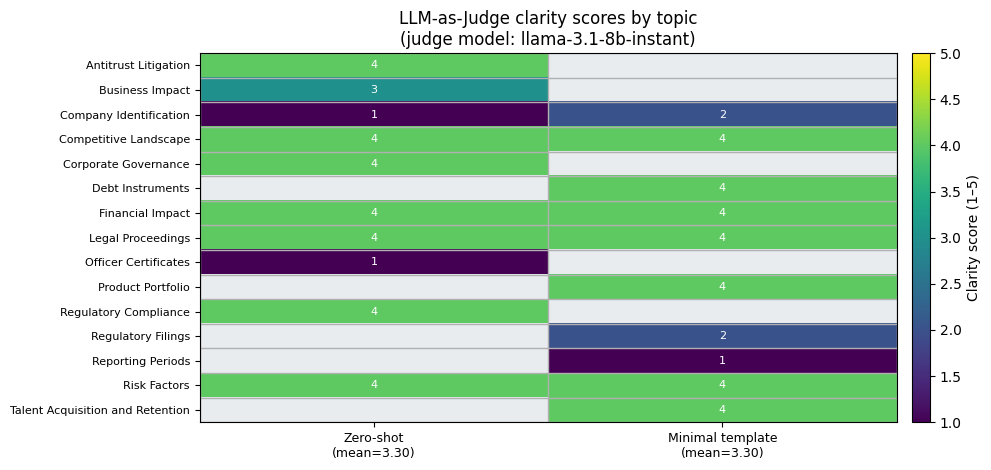

In [96]:
ZERO_PATH = Path("outputs") / f"zeroshot_LLM_judge.json"
MIN_PATH  = Path("outputs") / f"minimal_template_judge.json"

def load_judge_json(path: str) -> pd.DataFrame:

    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    df = pd.DataFrame(data)
    if not {"label", "score"}.issubset(df.columns):
        raise ValueError(f"{path} does not contain required keys: label, score")

    df["label"] = df["label"].astype(str)
    df["score"] = pd.to_numeric(df["score"], errors="coerce")
    df = df.dropna(subset=["score"]).set_index("label").sort_index()
    return df[["score"]]


# Load
zero_df = load_judge_json(ZERO_PATH)
min_df  = load_judge_json(MIN_PATH)

topics = sorted(set(zero_df.index).union(set(min_df.index)))
mat = pd.DataFrame(index=topics, columns=["Zero-shot", "Minimal template"], dtype=float)
mat.loc[zero_df.index, "Zero-shot"] = zero_df["score"].values
mat.loc[min_df.index,  "Minimal template"] = min_df["score"].values

mean_zero = np.nanmean(mat["Zero-shot"].values)
mean_min  = np.nanmean(mat["Minimal template"].values)

fig, ax = plt.subplots(figsize=(10, 4.8))

masked = np.ma.masked_invalid(mat.values)

im = ax.imshow(masked, aspect="auto", vmin=1, vmax=5)
ax.set_facecolor("#e9ecef")

ax.set_yticks(np.arange(len(mat.index)))
ax.set_yticklabels(mat.index, fontsize=8)

ax.set_xticks([0, 1])
ax.set_xticklabels(
    [f"Zero-shot\n(mean={mean_zero:.2f})", f"Minimal template\n(mean={mean_min:.2f})"],
    fontsize=9
)

ax.set_title(
    "LLM-as-Judge clarity scores by topic\n(judge model: llama-3.1-8b-instant)",
    fontsize=12
)

for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        val = mat.iat[i, j]
        if pd.notna(val):
            ax.text(j, i, f"{int(val)}", ha="center", va="center", fontsize=8, color="white")

cbar = fig.colorbar(im, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label("Clarity score (1–5)", rotation=90)

ax.set_xticks(np.arange(-.5, mat.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-.5, mat.shape[0], 1), minor=True)
ax.grid(which="minor", linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)

plt.tight_layout()
output_path= Path.cwd() / "Figures" / "Python-charts"
fig_name = 'baseline_clarity_matrix.pdf'
plt.savefig(output_path/fig_name, dpi=300, bbox_inches="tight")
plt.show()


In [58]:
model = "llama-3.1-8b-instant"
temperature = 0
llm_setting = LLM_setting.LLMSetting(MODEL=model, TEMPERATURE=temperature)
judge_llm = LLM_setting.setting(llm_setting)

In [59]:
ablation_llm_judge= {}

valid_runs = {vid: r for vid, r in runs_by_variant.items() if r.get("topics")}
for vid, run_obj in valid_runs.items():
    topics = run_obj.get("topics", [])

    if not topics:
        ablation_llm_judge[vid] = {
            "mean_clarity": math.nan,
            "ratings": [],
        }
        continue
    clarity_res = llm_as_judge_clarity_score(
        judge_llm=judge_llm,
        topics=topics,
        batch_size=10
      )

    mean_score = getattr(clarity_res, "mean_score", None)
    ratings = getattr(clarity_res, "ratings", None)

    if mean_score is None and isinstance(clarity_res, dict):
        mean_score = clarity_res.get("mean_score")
        ratings = clarity_res.get("ratings")

    ablation_llm_judge[vid] = {
        "mean_clarity": float(mean_score) if mean_score is not None else math.nan,
        "ratings": ratings if ratings is not None else [],
        "raw": clarity_res,
    }
means = [v["mean_clarity"] for v in ablation_llm_judge.values() if not math.isnan(v["mean_clarity"])]
print("Runs judged:", len(ablation_llm_judge))
print("Overall mean clarity (across variants):", float(np.mean(means)) if means else math.nan)

example_vid = next(iter(ablation_llm_judge.keys()))
print("\nExample variant:", example_vid)
print("Mean clarity:", ablation_llm_judge[example_vid]["mean_clarity"])
print("Ratings:", ablation_llm_judge[example_vid]["ratings"])

Runs judged: 7
Overall mean clarity (across variants): 4.0

Example variant: abl_minus_exemplars_delimiter
Mean clarity: 3.5
Ratings: [{'label': 'Financial Performance Impact', 'score': 4, 'rationale': 'The label is clear and the keywords are mostly consistent and informative, indicating a strong theme of financial performance impact.'}, {'label': 'Independent auditor report', 'score': 4, 'rationale': 'The label is clear and the keywords are mostly consistent and informative, indicating a strong theme of an independent auditor report.'}, {'label': 'Share repurchase program', 'score': 4, 'rationale': 'The label is clear and the keywords are mostly consistent and informative, indicating a strong theme of a share repurchase program.'}, {'label': 'Consolidated balance sheets', 'score': 3, 'rationale': "The label is somewhat clear, but the keywords include 'reporting date' and 'assets total', which are boilerplate artifacts, making the theme less clear."}, {'label': 'Manufacturing Purchase 

In [61]:
out_path = Path("outputs") / f"ablation_LLM_judge.json"
to_save = {
    vid: {
        "mean_clarity": v.get("mean_clarity"),
        "ratings": v.get("ratings", []),
        # store raw only if it's JSON-safe; otherwise drop it
        "raw": v.get("raw") if isinstance(v.get("raw"), (dict, list, str, int, float, bool, type(None))) else None,
    }
    for vid, v in ablation_llm_judge.items()
}

out_path.write_text(json.dumps(to_save, indent=2, ensure_ascii=False), encoding="utf-8")
print(f"Saved: {out_path}")

Saved: outputs/ablation_LLM_judge.json


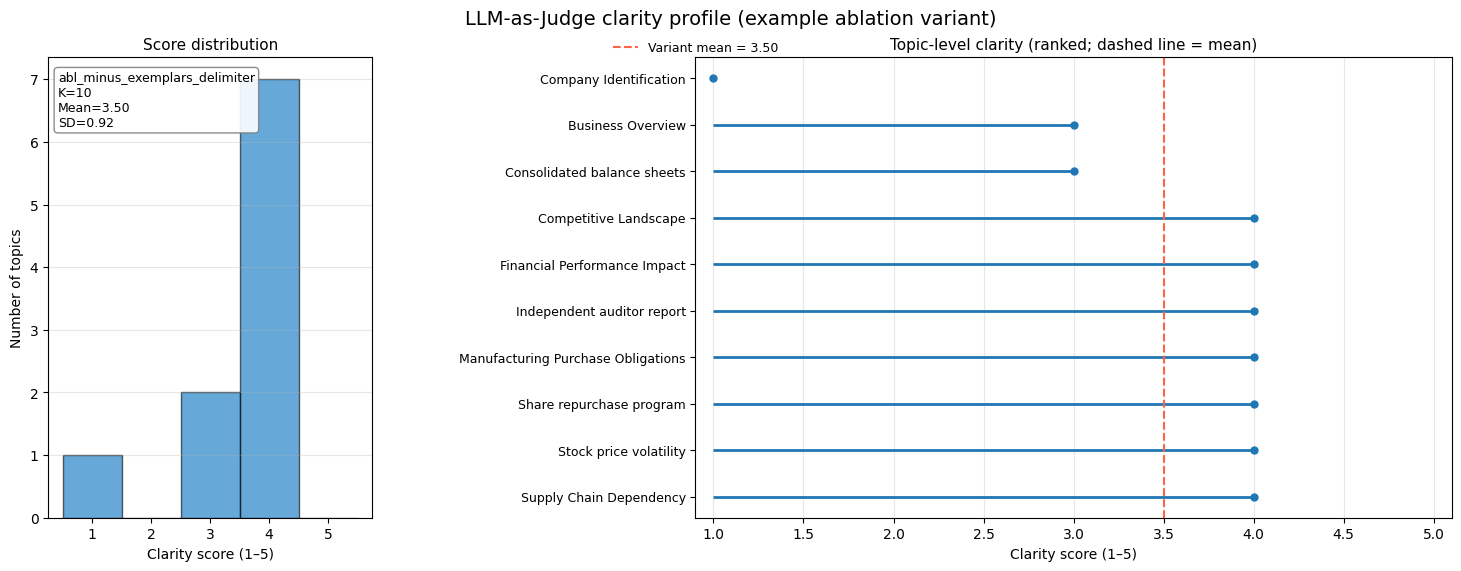

In [97]:
JSON_PATH = Path("outputs") / f"ablation_LLM_judge.json"

with JSON_PATH.open("r", encoding="utf-8") as f:
    ablation_llm_judge = json.load(f)

VARIANT_ID = "abl_minus_exemplars_delimiter"

if VARIANT_ID not in ablation_llm_judge:
    raise KeyError(
        f"Variant '{VARIANT_ID}' not found. Available keys:\n"
        + "\n".join(list(ablation_llm_judge.keys())[:50])
    )

variant = ablation_llm_judge[VARIANT_ID]
ratings = variant.get("ratings", [])

if not ratings:
    raise ValueError(f"No ratings found for variant '{VARIANT_ID}'.")

labels = [r["label"] for r in ratings]
scores = np.array([int(r["score"]) for r in ratings])
k = len(scores)
mean = float(np.mean(scores))
sd = float(np.std(scores, ddof=0))

fig = plt.figure(figsize=(14.5, 5.6), constrained_layout=True)
gs = fig.add_gridspec(1, 2, width_ratios=[1.2, 2.8], wspace=0.12)

ax_hist = fig.add_subplot(gs[0, 0])
ax_rank = fig.add_subplot(gs[0, 1])

fig.suptitle("LLM-as-Judge clarity profile (example ablation variant)", fontsize=14)

# Left: histogram
bins = np.arange(0.5, 5.6, 1.0)
ax_hist.hist(scores, bins=bins, edgecolor="black", alpha=0.6,color="#0070C0")
ax_hist.set_title("Score distribution", fontsize=11)
ax_hist.set_xlabel("Clarity score (1–5)")
ax_hist.set_ylabel("Number of topics")
ax_hist.set_xticks([1, 2, 3, 4, 5])
ax_hist.grid(True, axis="y", alpha=0.3)

stats_text = (
    f"{VARIANT_ID}\n"
    f"K={k}\n"
    f"Mean={mean:.2f}\n"
    f"SD={sd:.2f}"
)
ax_hist.text(
    0.03, 0.97, stats_text,
    transform=ax_hist.transAxes,
    va="top", ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.9)
)

order = np.lexsort((np.array(labels), scores))
labels_ranked = [labels[i] for i in order]
scores_ranked = scores[order]
y = np.arange(len(labels_ranked))

ax_rank.hlines(y=y, xmin=1, xmax=scores_ranked, linewidth=2)
ax_rank.plot(scores_ranked, y, "o", markersize=5)

mean_line = ax_rank.axvline(
    mean, linestyle="--", linewidth=1.5, color="tomato",
    label=f"Variant mean = {mean:.2f}"
)

ax_rank.set_yticks(y)
ax_rank.set_yticklabels(labels_ranked, fontsize=9)
ax_rank.invert_yaxis()
ax_rank.set_xlim(0.9, 5.1)
ax_rank.set_xlabel("Clarity score (1–5)")
ax_rank.set_title("Topic-level clarity (ranked; dashed line = mean)", fontsize=11)
ax_rank.grid(True, axis="x", alpha=0.3)

ax_rank.legend(
    handles=[mean_line],
    loc="center",
    bbox_to_anchor=(0.0, 1.02),
    frameon=False,
    fontsize=9,
    borderaxespad=0.0
)

output_path= Path.cwd() / "Figures" / "Python-charts"
fig_name = 'abl_minus_exemplars_delimiter_clarity_profile_v2.pdf'
plt.savefig(output_path/fig_name, dpi=300, bbox_inches="tight")

plt.show()


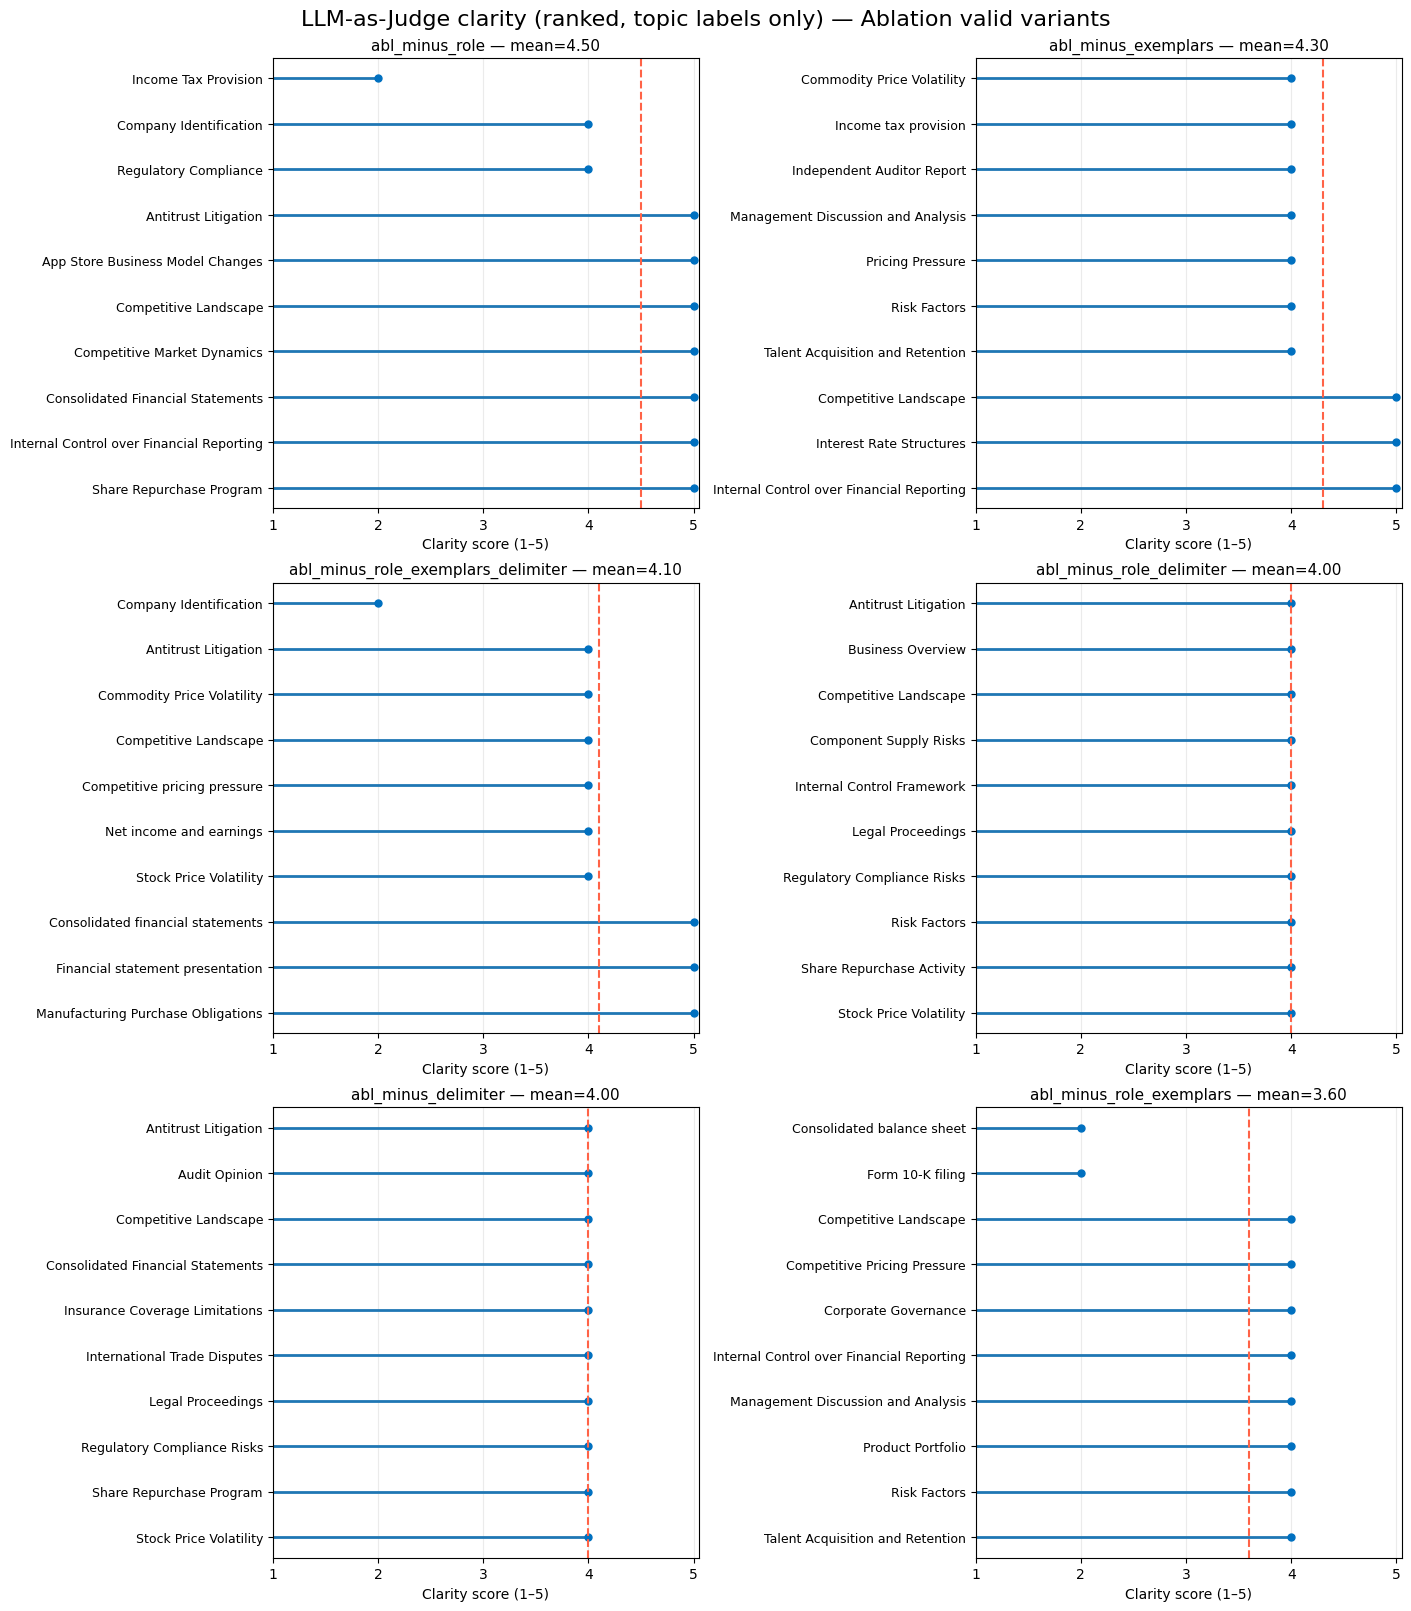

In [98]:
JSON_PATH = Path("outputs") / f"ablation_LLM_judge.json"
with JSON_PATH.open("r", encoding="utf-8") as f:
    ablation = json.load(f)

def is_valid_variant(v: dict) -> bool:
    mean = v.get("mean_clarity", None)
    ratings = v.get("ratings", [])
    return (
        mean is not None
        and np.isfinite(mean)
        and isinstance(ratings, list)
        and len(ratings) > 0
    )
valid = {vid: v for vid, v in ablation.items() if is_valid_variant(v)}

if not valid:
    raise ValueError("No valid variants found (mean_clarity NaN or ratings empty).")

variant_ids = sorted(valid.keys(), key=lambda k: valid[k]["mean_clarity"], reverse=True)[:6]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 16), constrained_layout=True)
axes = axes.flatten()

fig.suptitle("LLM-as-Judge clarity (ranked, topic labels only) — Ablation valid variants", fontsize=16)

for ax, vid in zip(axes, variant_ids):
    v = valid[vid]
    mean = float(v["mean_clarity"])
    ratings = v["ratings"]

    labels = [r["label"] for r in ratings]
    scores = np.array([int(r["score"]) for r in ratings], dtype=int)

    order = np.lexsort((np.array(labels, dtype=str), scores))
    labels_ranked = [labels[i] for i in order]
    scores_ranked = scores[order]

    y = np.arange(len(labels_ranked))

    # Lollipop
    ax.hlines(y=y, xmin=1, xmax=scores_ranked, linewidth=2)
    ax.plot(scores_ranked, y, "o", markersize=5,color="#0070C0")

    # Mean line
    ax.axvline(mean, linestyle="--", linewidth=1.5,color="tomato")

    # Axes
    ax.set_yticks(y)
    ax.set_yticklabels(labels_ranked, fontsize=9)
    ax.invert_yaxis()
    ax.set_xlim(1, 5.05)
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_xlabel("Clarity score (1–5)")
    ax.grid(True, axis="x", alpha=0.25)

    ax.set_title(f"{vid} — mean={mean:.2f}", fontsize=11)

for j in range(len(variant_ids), len(axes)):
    axes[j].axis("off")


output_path= Path.cwd() / "Figures" / "Python-charts"
fig_name = 'ablation_clarity_grid_3x2.pdf'
plt.savefig(output_path/fig_name, dpi=300, bbox_inches="tight")

plt.show()

In [59]:
for vid, obj in ablation_llm_judge.items():
    ratings = obj.get("ratings") or []
    if not ratings:
        continue

    mean_clarity = obj.get("mean_clarity")
    mean_str = f"{mean_clarity:.2f}" if isinstance(mean_clarity, (int, float)) else "NaN"

    print("\n" + "=" * 90)
    print(f"Variant: {vid} | mean clarity: {mean_str} | topics rated: {len(ratings)}")
    print("-" * 90)

    for i, r in enumerate(ratings, start=1):
        label = r.get("label", "<missing label>")
        score = r.get("score", None)
        score_str = str(score) if score is not None else "NA"
        print(f"T{i:02d}  score={score_str}  |  {label}")


Variant: abl_minus_exemplars_delimiter | mean clarity: 3.50 | topics rated: 10
------------------------------------------------------------------------------------------
T01  score=4  |  Financial Performance Impact
T02  score=4  |  Independent auditor report
T03  score=4  |  Share repurchase program
T04  score=3  |  Consolidated balance sheets
T05  score=4  |  Manufacturing Purchase Obligations
T06  score=4  |  Stock price volatility
T07  score=4  |  Supply Chain Dependency
T08  score=3  |  Business Overview
T09  score=1  |  Company Identification
T10  score=4  |  Competitive Landscape

Variant: abl_minus_role_exemplars_delimiter | mean clarity: 4.10 | topics rated: 10
------------------------------------------------------------------------------------------
T01  score=4  |  Antitrust Litigation
T02  score=5  |  Consolidated financial statements
T03  score=5  |  Financial statement presentation
T04  score=5  |  Manufacturing Purchase Obligations
T05  score=4  |  Net income and earnin